## Kaggle Token

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload kaggle.json from kaggle_account > your_profile > API section > Create new token
files.upload();

Saving kaggle.json to kaggle.json


## Download Dataset and Extract

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from kaggle
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from tqdm.notebook import tqdm
import zipfile

zip_file_path = 'ocular-disease-recognition-odir5k.zip'
extracted_dir = 'dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc='Extracting'):
        zip_ref.extract(file, extracted_dir)

print(f"Dataset extracted to {extracted_dir}")

Extracting:   0%|          | 0/14394 [00:00<?, ?it/s]

Dataset extracted to dataset


## Load Datasets and csv files

In [5]:
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import os

In [6]:
df = pd.read_csv("dataset/full_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
# Function to check if a given text contains the word "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [8]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [9]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

left_cataract[:10], right_cataract[:10]

(array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
        '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
        '465_left.jpg', '477_left.jpg'], dtype=object),
 array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
        '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
        '553_right.jpg', '560_right.jpg'], dtype=object))

In [10]:
len(left_cataract), len(right_cataract)

(304, 290)

In [11]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:10]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg'], dtype=object)

In [12]:
cataract = np.concatenate((left_cataract,right_cataract), axis=0)
normal = np.concatenate((left_normal,right_normal), axis=0)

In [13]:
len(cataract),len(normal)

(594, 500)

## PyTorch

In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, TensorDataset, DataLoader

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [15]:
class CustomDataset(Dataset):
    def __init__(self, image_category, label, dataset_dir, image_size=224):
        self.image_category = image_category
        self.label = label
        self.dataset_dir = dataset_dir
        self.image_size = image_size
        self.data = self.create_dataset()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

    def create_dataset(self):
        dataset = []
        dataset_label = []
        for img in tqdm(self.image_category):
            image_path = os.path.join(self.dataset_dir, img)
            try:
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (self.image_size, self.image_size))
            except:
                continue

            dataset.append([np.array(image), np.array(self.label)])
        random.shuffle(dataset)
        return dataset

In [16]:
dataset_cataract = CustomDataset(image_category = cataract,
                                 label = 1,
                                 dataset_dir = "dataset/preprocessed_images/",
                                 image_size = 224)

dataset_normal = CustomDataset(normal, 0, "dataset/preprocessed_images/", 224)

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
dataset = ConcatDataset([dataset_cataract, dataset_normal])

print("Combined dataset length:", len(dataset))

Combined dataset length: 1088


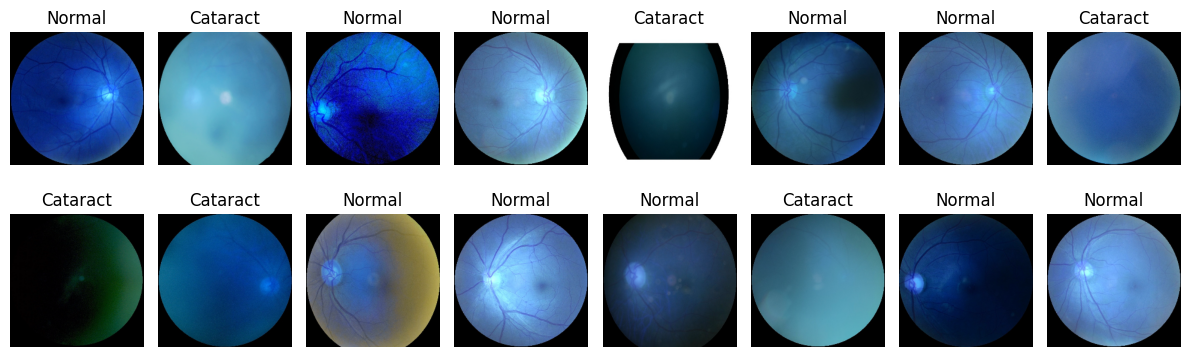

In [18]:
plt.figure(figsize=(12, 4))
rows, cols = 2, 8
for i in range(1, rows*cols + 1):
  sample = random.choice(range(len(dataset)))
  image = dataset[sample][0]
  category = dataset[sample][1]

  label = "Normal" if category == 0 else "Cataract"

  plt.subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(label)
  plt.axis(False);
plt.tight_layout()

In [19]:
dataset[0][0].shape

(224, 224, 3)

In [20]:
X = np.array([i[0] for i in dataset]).reshape(-1, 224, 224, 3)
y = np.array([i[1] for i in dataset])

### Conversion of datas in arrays to tensor format

In [21]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

# View the first ten label samples
X[0], y[:10]

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 tensor([1, 

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

len(X_train), len(X_test), y_train[:10]

(870, 218, tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1]))

In [23]:
X_train.shape

torch.Size([870, 224, 224, 3])

In [24]:
# Permute the color channel index to front
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [25]:
# Turn datasets into batches
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)      # Shuffle false cuz already shuffled using sklearn->train_test_spilt

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

# Length of datalaoders after batching datasets
len(train_dataloader), len(test_dataloader)

(28, 7)

In [26]:
# Checking shape of train_images and train_labels dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## TinyVGG BaseModel

In [27]:
class CataractModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super(CataractModel, self).__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(hidden_units)  # Batch normalization for stabilization
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(2 * hidden_units)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(2 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(output_shape)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28 * output_shape, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout for regularization
        nn.Linear(512, output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)
    return x

In [28]:
model = CataractModel(3, 10, 2).to(device)   # (3, 10, 2) -> (Color_channel, hidden_units, output_shape)
model, next(model.parameters()).device

(CataractModel(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(40, 2, kernel_size=(3, 3), stride=(1, 1), padding=

## Train and Test DataLoaders

In [29]:
!pip install torchmetrics

In [30]:
# Import Accuracy
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = "binary",
                                 num_classes = 2).to(device)

In [50]:
# Setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [53]:
# Train and Test function
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0

  model.to(device)
  train_losses = []
  train_accuracies = []
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += torchmetrics_accuracy(y,
                                       y_pred.argmax(dim = 1)) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss.item())
  train_accuracies.append(train_acc.item())
  print(f'Train loss: {train_loss:.4f} ---- Train acc: {train_acc:.2f}%')
  return train_losses, train_accuracies

def test_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  test_losses = []
  test_accuracies = []

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += torchmetrics_accuracy(y,
                                        test_pred.argmax(dim = 1)) * 100
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f'Test loss: {test_loss:.4f} ---- Test acc: {test_acc:.2f}%')
  return test_losses, test_accuracies

In [54]:
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 15
train_losses_history = []
train_accuracies_history = []
test_losses_history = []
test_accuracies_history = []

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_losses, train_accuracies = train_step(model, train_dataloader, loss_fn, optimizer,
                                              torchmetrics_accuracy, device)
  test_losses, test_accuracies = test_step(model, test_dataloader, loss_fn, optimizer,
                                           torchmetrics_accuracy, device)
  # Calculate avg. loss and accuracy
  avg_train_loss = sum(train_losses) / len(train_losses)
  avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
  avg_test_loss = sum(test_losses) / len(test_losses)
  avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

  train_losses_history.append(avg_train_loss)
  train_accuracies_history.append(avg_train_accuracy)
  test_losses_history.append(avg_test_loss)
  test_accuracies_history.append(avg_test_accuracy)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0


ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 2])) is deprecated. Please ensure they have the same size.

## Plot loss curves and accuracy curves

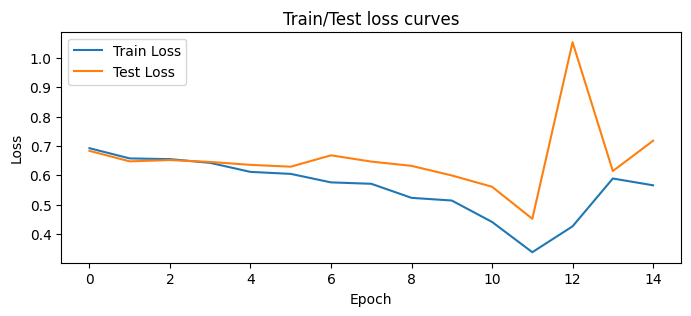

In [34]:
# Plot loss curves
epoch = np.arange(0, len(train_losses_history))

plt.figure(figsize=(8, 3))
plt.plot(epoch, train_losses_history, label="Train Loss")
plt.plot(epoch, test_losses_history, label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

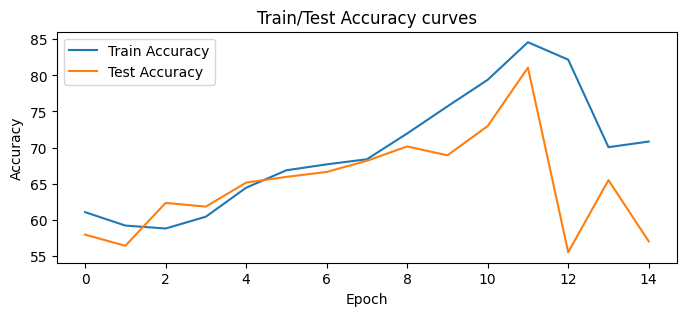

In [35]:
# Plot accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(epoch, train_accuracies_history, label="Train Accuracy")
plt.plot(epoch, test_accuracies_history, label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

In [48]:
torch.manual_seed(42)

def eval_model(model,
               data_loader,
               loss_fn,
               accuracy_fn,
               device = device):
    loss, acc = 0, 0
    # accuracy_fn.reset()
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    # accuracy = accuracy_fn.compute()
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


In [49]:
model_results = eval_model(model = model,
                          data_loader = test_dataloader,
                          loss_fn = loss_fn,
                          accuracy_fn = torchmetrics_accuracy)

model_results

TypeError: BinaryStatScores.update() got an unexpected keyword argument 'y_true'

## Making Predictions

In [38]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [39]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k = 20):
  test_samples.append(sample)
  test_labels.append(label)

In [40]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [41]:
# Make Predictions
pred_probs = make_predictions(model,
                              test_samples,
                              device)

# Convert prediction proabbilities to labels
pred_classes = pred_probs.argmax(dim = 1)
print(pred_classes, test_labels, sep = '\n')

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0])
[tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0)]


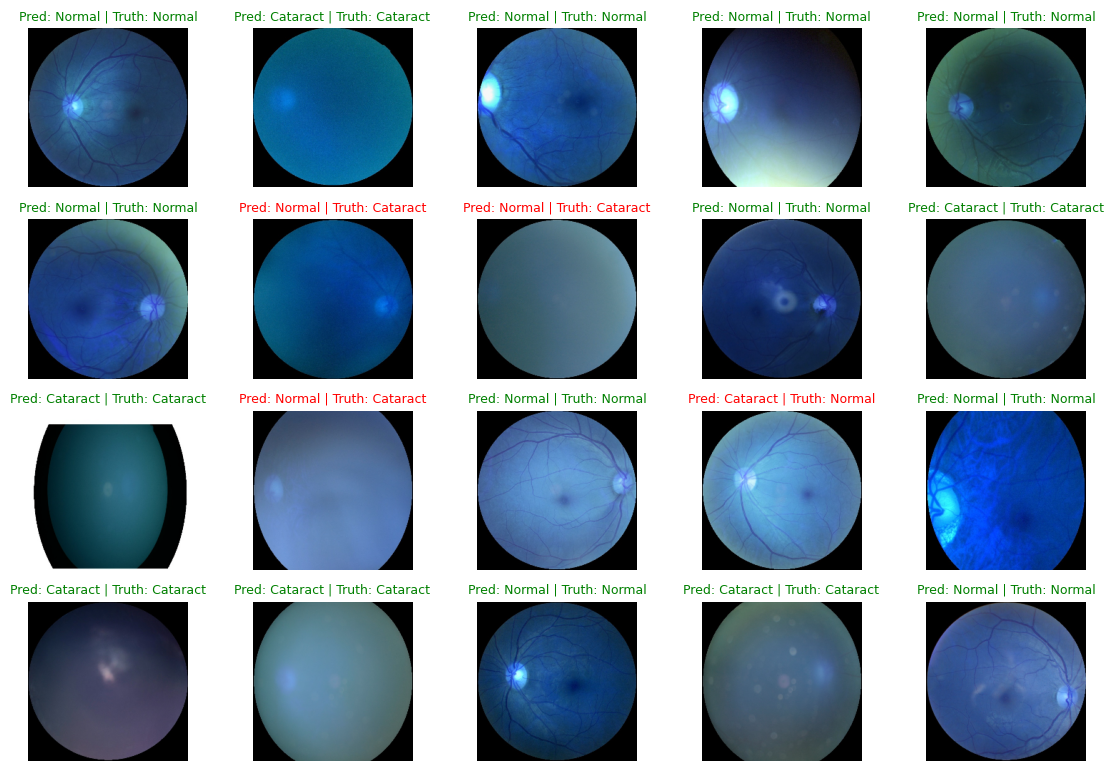

In [42]:
# Plot predictions
plt.figure(figsize=(14, 12))
nrows, ncols = 5, 5
for i, sample in enumerate(test_samples):
  class_name = np.array(['Normal', 'Cataract'])
  plt.subplot(nrows, ncols, i + 1)
  # Convert PyTorch tensor to NumPy array
  normalized_sample = sample.permute(1, 2, 0).numpy()
  normalized_sample = normalized_sample / 255.0  # Normalize pixel values to [0, 1]
  plt.imshow(normalized_sample)
  # print(normalized_sample.shape)
  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check equality between pred and truth and change color of title
  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False)
plt.show()


## Plot Confusion Matrix

In [43]:
from tqdm.auto import tqdm

# Make prediciton with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader,
                   desc = "Making predictions...\t"):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1 )
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...	:   0%|          | 0/7 [00:00<?, ?it/s]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 218)

In [44]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


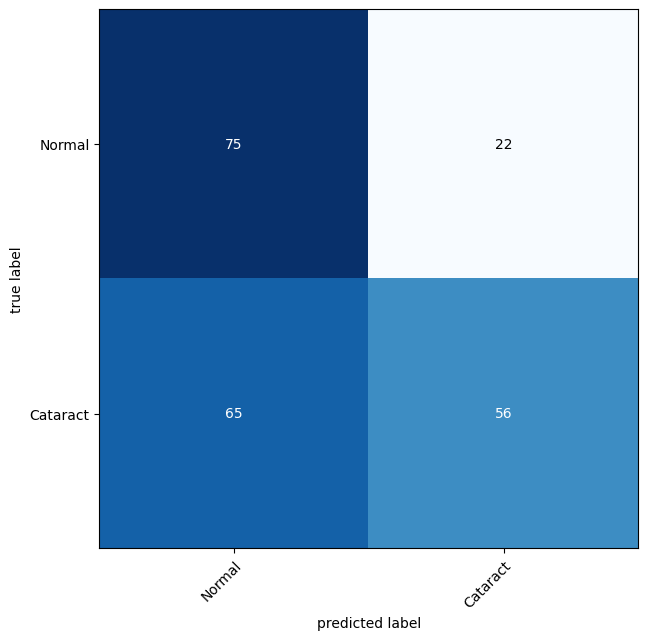

In [45]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_name), task = 'binary')
# print(y_pred_tensor, test_data.targets)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize = (10, 7)
);

## Saving and Loading Model

In [46]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "EyeCataractDetectModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/EyeCataractDetectModel.pth


In [47]:
loaded_model = CataractModel(3, 10, 2)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model = loaded_model.to(device)      # Send model to GPU
# loaded_model = loaded_model.to('cpu')     # For model to load in cpu and check inference